# **SETTING THE ENVIRONMENT**

In [1]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import array
from numpy import asarray
from numpy import zeros

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Flatten, GlobalMaxPool1D, Embedding, Conv1D, LSTM, Activation, Dropout, Dense
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment_Anlaysis_with_LSTM/a1_IMDB_Dataset.csv')

In [3]:
df.shape

(50000, 2)

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

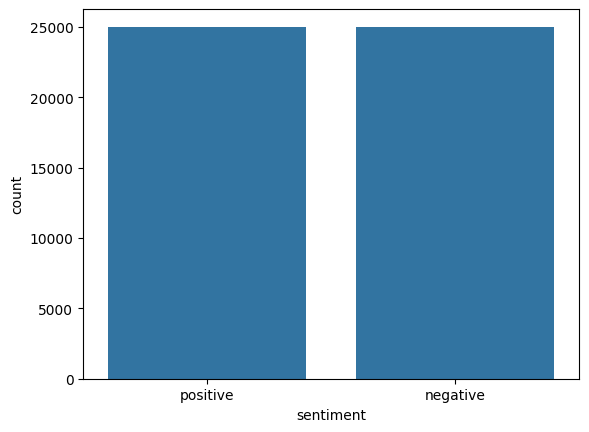

In [6]:
sns.countplot(x='sentiment', data=df)

# **DATA PREPROCESSING**

In [7]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    """Removes HTML tags: replaces anything between opening and closing <> with empty space"""
    return TAG_RE.sub('', text)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
def preprocess_text(text):
    """Cleans text data up, leaving only 2 or more char long non-stopwords composed of A-Z & a-z only in lowercase"""
    sentence = text.lower()

    # Remove HTML Tags
    sentence = remove_tags(sentence)

    # Remove Punctuatioons and Numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single Character Removal
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

    # Remove Mutiple Spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [11]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(df['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
# Sample cleaned up movie review
X[2]
# As we shall use Word Embedding, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [13]:
# Converting sentiment labels to 0 & 1
y = df.sentiment

y = np.array(list(map(lambda x: 1 if x == 'positive' else 0, y)))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

# **PREPARING EMBEDDING LAYER**

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras.**

In [15]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)

X_test = word_tokenizer.texts_to_sequences(X_test)

In [16]:
# 1 to store dimensions for words for which no pretrained word embbeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [17]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
# Load GloVe word embedding and create an Embeddings Dictionary

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Sentiment_Anlaysis_with_LSTM/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [19]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in ur corpus

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)

    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# **MODEL TRAINING NETWORK**

# Simple Neural Network

In [20]:
# Neural Network Architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [21]:
# Model Compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [22]:
# Model Training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 3s 4ms/step - loss: 0.5586 - acc: 0.7135 - val_loss: 0.5045 - val_acc: 0.7625
Epoch 2/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4488 - acc: 0.7971 - val_loss: 0.4979 - val_acc: 0.7632
Epoch 3/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4101 - acc: 0.8166 - val_loss: 0.5355 - val_acc: 0.7500
Epoch 4/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3892 - acc: 0.8289 - val_loss: 0.5110 - val_acc: 0.7605
Epoch 5/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3741 - acc: 0.8360 - val_loss: 0.5235 - val_acc: 0.7579
Epoch 6/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3619 - acc: 0.8435 - val_loss: 0.5490 - val_acc: 0.7513


In [23]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5710 - acc: 0.7474


In [24]:
# Model Performance

print('Test Score : ', score[0])
print('Test Accuracy : ', score[1])

Test Score :  0.5709913969039917
Test Accuracy :  0.7473999857902527


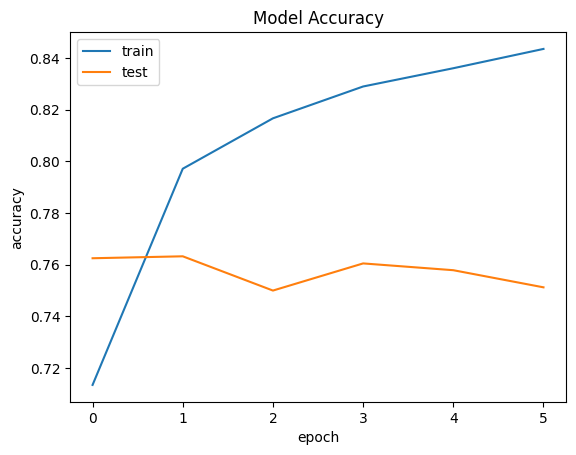

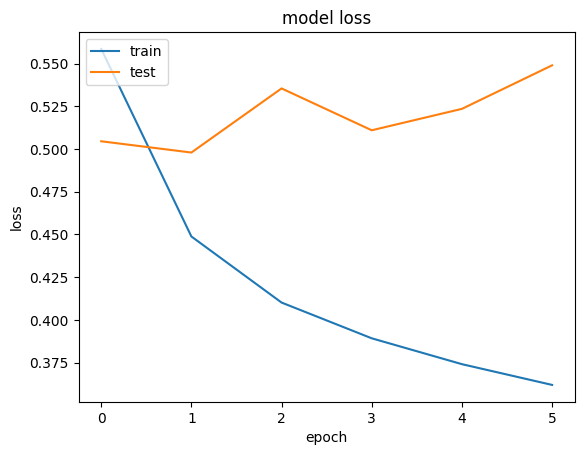

In [25]:
# Model Performance Charts

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Convolutional Neural Network**

In [26]:
# Neural NEtwork Architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPool1D())
cnn_model.add(Dense(1, activation='sigmoid'))


In [27]:
# Model Compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [28]:
# Model Training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 4s 7ms/step - loss: 0.4904 - acc: 0.7609 - val_loss: 0.3930 - val_acc: 0.8242
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3466 - acc: 0.8518 - val_loss: 0.3548 - val_acc: 0.8461
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.2903 - acc: 0.8828 - val_loss: 0.3449 - val_acc: 0.8496
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.2434 - acc: 0.9097 - val_loss: 0.3496 - val_acc: 0.8469
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.2074 - acc: 0.9261 - val_loss: 0.3558 - val_acc: 0.8476
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.1681 - acc: 0.9475 - val_loss: 0.3401 - val_acc: 0.8533


In [29]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.3410 - acc: 0.8562


In [30]:
# Model Performance

print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.3409545123577118
Test Accuracy:  0.8561999797821045


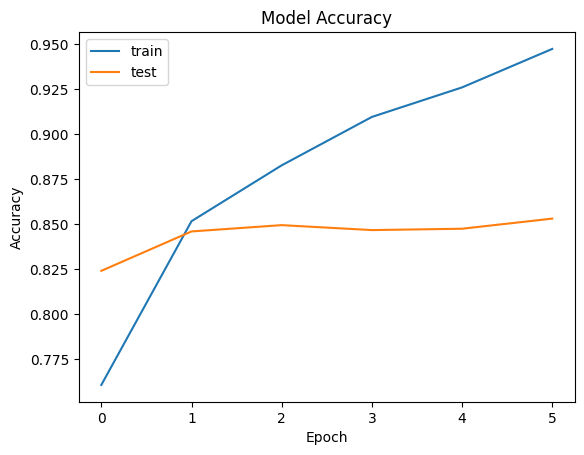

In [32]:
# Model Performance Charts

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Recurrent Neural Network (LSTM)

In [33]:
# Neural Network Architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [34]:
# Model Compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [35]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 6s 15ms/step - loss: 0.5143 - acc: 0.7474 - val_loss: 0.4399 - val_acc: 0.8005
Epoch 2/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4194 - acc: 0.8111 - val_loss: 0.3841 - val_acc: 0.8273
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3710 - acc: 0.8391 - val_loss: 0.3493 - val_acc: 0.8531
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3464 - acc: 0.8503 - val_loss: 0.3561 - val_acc: 0.8497
Epoch 5/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3266 - acc: 0.8620 - val_loss: 0.3719 - val_acc: 0.8267
Epoch 6/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3054 - acc: 0.8733 - val_loss: 0.3238 - val_acc: 0.8627


In [36]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.3262 - acc: 0.8618


In [37]:
# Model Performance

print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.32615911960601807
Test Accuracy:  0.8618000149726868


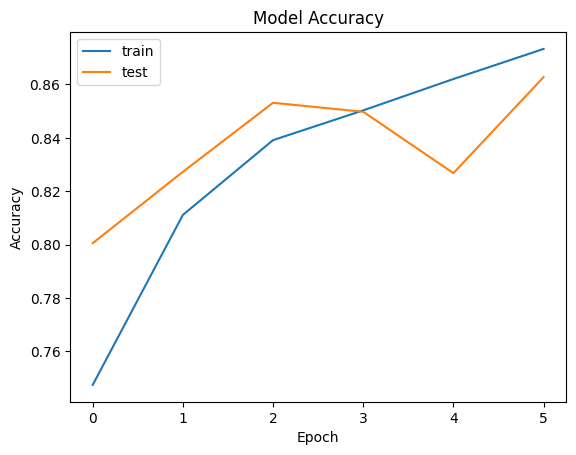

In [38]:
# Model Performancce Charts

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# Save the model as a h5 file for possible use later

lstm_model.save(f"./cl_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Making Predictions on Live IMDB Data

In [40]:
# Load previously trained LSTM Model
# model_path = './cl_lstm_model_acc_0.856.h5'

In [43]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("/content/drive/MyDrive/Sentiment_Anlaysis_with_LSTM/a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [44]:
unseen_processed = []
for review in sample_reviews['Review Text']:
    review = preprocess_text(review)
    unseen_processed.append(review)

In [45]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [46]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 343ms/step


array([[0.8009807 ],
       [0.9843369 ],
       [0.26847658],
       [0.55480015],
       [0.9408864 ],
       [0.05098752]], dtype=float32)

In [47]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.0
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.8
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.7
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,5.5
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.4
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.5
